<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

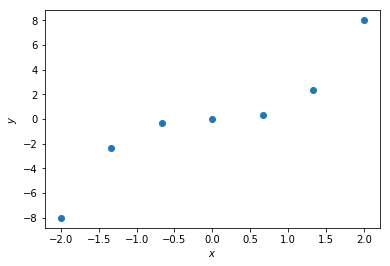

In [181]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [182]:
X.reshape((7,1))

array([[-2.        ],
       [-1.33333333],
       [-0.66666667],
       [ 0.        ],
       [ 0.66666667],
       [ 1.33333333],
       [ 2.        ]])

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
reg_tree = DecisionTreeRegressor(random_state=17, max_depth=3).fit(X.reshape((7,1)), y)
reg_tree_pred = reg_tree.predict(X.reshape((7,1)))

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

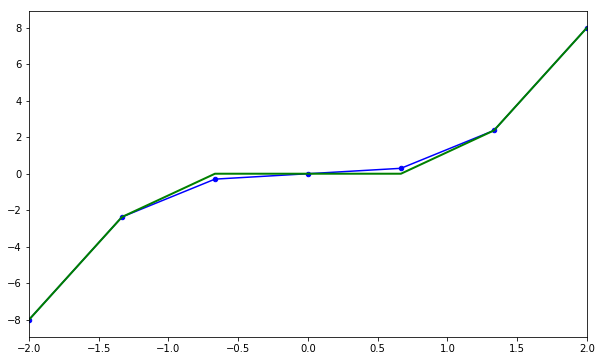

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, "b")
plt.scatter(X, y, c="b", s=20)
plt.plot(X, reg_tree_pred, "g", lw=2)
plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [189]:
len_x = len(X)
np.sum(y)/len(X)
1/len_x*(np.sum((y -  np.sum(y)/len(X))**2))
y

array([-8.        , -2.37037037, -0.2962963 ,  0.        ,  0.2962963 ,
        2.37037037,  8.        ])

In [190]:
def regression_var_criterion(X, y, t):
    len_x = len(X)
    mean_y = np.sum(y)/len(X)
    d_x = 1/len_x*(np.sum((y -  mean_y)**2))
    return d_x

In [204]:
def q_x(X,y,t):
    len_x = len(X)
    
    left, right = list(), list()
    left_y, right_y = list(), list()
    for val in X:
        if val < t:
            left.append(val)
            left_y.append(y[np.where(X == val)])
        else:
            right.append(val)
            right_y.append(y[np.where(X == val)])
            
    q_x = regression_var_criterion(X,y,t) - len(left)/len(X)*regression_var_criterion(left, left_y, t) \
            - len(right)/len(X)*regression_var_criterion(right, right_y, t)
    return q_x
    

In [208]:
len_x = len(X)
t = 0

left, right = list(), list()
left_y, right_y = list(), list()

for val in X:
    if val < t:
        left.append(val)
        left_y.append(y[np.where(X == val)])
    else:
        right.append(val)
        right_y.append(y[np.where(X == val)])

q_x = regression_var_criterion(X,y,t) - len(left)/len(X)*regression_var_criterion(left, left_y, t) \
        - len(right)/len(X)*regression_var_criterion(right, right_y, t)

In [209]:
q_x

9.481481481481481

In [222]:
t_range = np.arange(-1.9,2,(1.9+1.9)/6)
q_t_range = list()
for t in t_range:
    left, right = list(), list()
    left_y, right_y = list(), list()

    for val in X:
        if val < t:
            left.append(val)
            left_y.append(y[np.where(X == val)])
        else:
            right.append(val)
            right_y.append(y[np.where(X == val)])

    q_x = regression_var_criterion(X,y,t) - len(left)/len(X)*regression_var_criterion(left, left_y, t) \
            - len(right)/len(X)*regression_var_criterion(right, right_y, t) 
    q_t_range.append(q_x)
        

In [228]:
t

1.8999999999999999

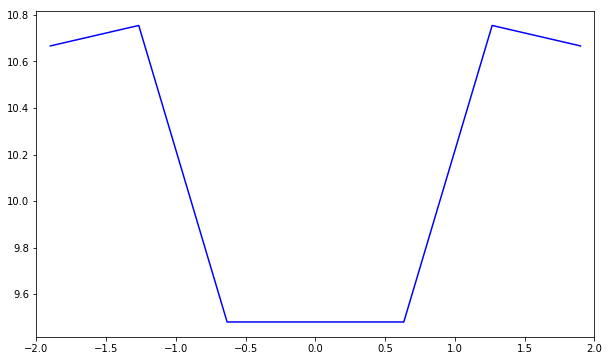

In [229]:
plt.figure(figsize=(10, 6))
plt.plot(t_range, q_t_range, "b")
plt.xlim([-2, 2])
#plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет - X

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
# Ваш код здесь

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [153]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [154]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [155]:
df['age'] = np.round(df.age/360,0)

In [156]:
df = pd.get_dummies(data=df, columns=['cholesterol', 'gluc'])

In [157]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,51.0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,56.0,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,52.0,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,49.0,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,49.0,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


In [158]:
y = df.cardio

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [159]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['cardio'], axis = 1).values, y.values,
                                                      test_size = 0.3, random_state =17 ) # Ваш код здесь


Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

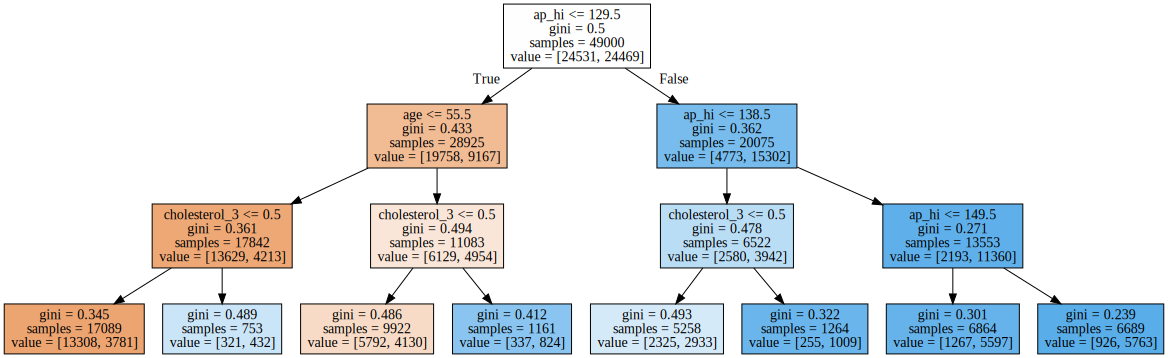

In [90]:
first_tree = DecisionTreeClassifier(max_depth=3, random_state= 17)
first_tree.fit(X_train, y_train)

from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(first_tree, feature_names=df.drop(['cardio'], axis = 1).columns,
                out_file=None, filled=True)
graph = graphviz.Source(dot_data)  
graph 



**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [95]:
tree_pred = first_tree.predict(X_valid)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [97]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(first_tree, tree_params, n_jobs= -1, verbose= True, cv = 5)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


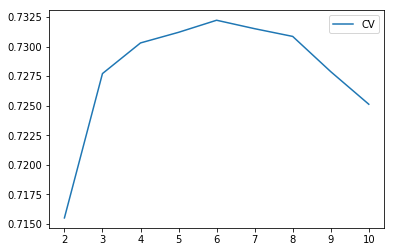

In [113]:
from sklearn.model_selection import cross_val_score

cv_scores, valid_scores = [], []
max_depth = list(range(2,11))

%time 
for d in max_depth:
    gr_tree = DecisionTreeClassifier(max_depth = d)
    cv_scores.append(np.mean(cross_val_score(gr_tree, X_train, y_train, cv=5)))
    gr_tree.fit(X_train, y_train)
    #valid_scores.append(accuracy_score(y_valid, gr_tree.predict(X_valid)))

plt.plot(max_depth, cv_scores, label='CV')
#plt.plot(max_depth, valid_scores, label='validation')
#plt.title('Easy task. kNN fails')
plt.legend();

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [99]:
print("Best max_depth:", tree_grid.best_params_)
print("Accuracy score:", tree_grid.best_score_)

Best max_depth: {'max_depth': 6}
Accuracy score: 0.732204081633


In [109]:
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_valid, tree_pred)
acc1

acc2 = accuracy_score(y_valid, tree_grid.predict(X_valid))
(acc2-acc1)/acc1*100 

0.64699280385553926

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет - X
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [160]:
df['age_45_50'] = 0
df.loc[(df['age'] >= 45.0) & (df['age']< 50.0),'age_45_50']= 1
df['age_50_55'] = 0
df.loc[(df['age'] >= 50.0) & (df['age']< 55.0),'age_50_55']= 1
df['age_55_60'] = 0
df.loc[(df['age'] >= 55.0) & (df['age']< 60.0),'age_55_60']= 1
df['age_60_65'] = 0
df.loc[(df['age'] >= 60.0) & (df['age']< 65.0),'age_60_65']= 1

In [161]:
df['ap_hi_120_140'] = 0
df.loc[(df.ap_hi >= 120) & (df.ap_hi< 140), 'ap_hi_120_140'] = 1

df['ap_hi_140_160'] = 0
df.loc[(df.ap_hi >= 140) & (df.ap_hi< 160), 'ap_hi_140_160'] = 1

df['ap_hi_160_180'] = 0
df.loc[(df.ap_hi >= 160) & (df.ap_hi< 180), 'ap_hi_160_180'] = 1

In [162]:
gender1 = {1:"f", 2:"m"}
df = df.replace({'gender': gender1})
gender2 = {"f":0, "m":1}
df = df.replace({'gender': gender2})

In [164]:
df['male'] = df.gender
df.drop('gender', axis =1, inplace= True)

In [165]:
df.head()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,...,gluc_2,gluc_3,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,male
id,,,,,,,,,,,,,,,,,,,,,
0,51.0,168,62.0,110,80,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
1,56.0,156,85.0,140,90,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
2,52.0,165,64.0,130,70,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,49.0,169,82.0,150,100,0,0,1,1,1,...,0,0,1,0,0,0,0,1,0,1
4,49.0,156,56.0,100,60,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [168]:
cols = ['ap_hi_120_140', 'ap_hi_140_160','ap_hi_160_180', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3',
        'age_45_50', 'age_50_55', 'age_55_60', 'age_60_65', 'smoke', 'male',  'cardio']

df_new = df[cols]

In [169]:
df_new.head()

,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,cholesterol_1,cholesterol_2,cholesterol_3,age_45_50,age_50_55,age_55_60,age_60_65,smoke,male,cardio
id,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,1,0,0,0,1,0,0,1,0,0,0,1
2,1,0,0,0,0,1,0,1,0,0,0,0,1
3,0,1,0,1,0,0,1,0,0,0,0,1,1
4,0,0,0,1,0,0,1,0,0,0,0,0,0


In [171]:
new_tree = DecisionTreeClassifier(max_depth = 3, random_state= 17)
X_train_new = df_new.drop('cardio', axis = 1).values
y_train_new = df_new.cardio.values
new_tree.fit(X_train_new, y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

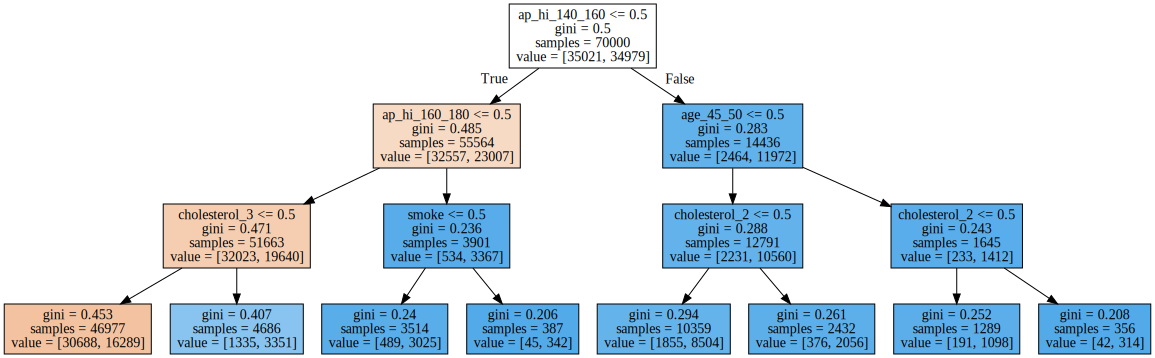

In [172]:
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(new_tree, feature_names=df_new.drop(['cardio'], axis = 1).columns,
                out_file=None, filled=True)
graph = graphviz.Source(dot_data)  
graph 